In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#1(a)
scores = pd.read_csv("CFB2019_scores.csv", header = None)
scores.columns = ['Team_A_index','Team_A_points',
                'Team_B_index', 'Team_B_points']
scores.head(10)

,Team_A_index,Team_A_points,Team_B_index,Team_B_points
0,695,34,141,14
1,392,20,218,24
2,29,38,270,45
3,721,6,531,16
4,769,45,560,22
5,9,19,7,24
6,317,7,31,30
7,464,10,46,41
8,436,3,80,46
9,687,30,85,12


In [4]:
scores['Team_A_index'].nunique()

769

In [5]:
#construct random walk matrix
RW_M = np.zeros((scores['Team_A_index'].nunique(), scores['Team_A_index'].nunique()))
#team rankings
for i in range(0, scores.shape[0]):
    
    j1=scores.iloc[i,:].Team_A_index-1
    j2=scores.iloc[i,:].Team_B_index-1
    points_j1=scores.iloc[i,:].Team_A_points
    points_j2=scores.iloc[i,:].Team_B_points
    #teamA WIN
    if points_j1 > points_j2:
        RW_M[int(j1), int(j1)] += 1+points_j1/(points_j1+points_j2)
        RW_M[int(j2), int(j2)] += points_j2/(points_j1+points_j2)
        RW_M[int(j1), int(j2)] += points_j2/(points_j1+points_j2)
        RW_M[int(j2), int(j1)] += 1+points_j1/(points_j1+points_j2)
    #teamB WIN
    elif points_j1 < points_j2:
        RW_M[int(j1), int(j1)] += points_j1/(points_j1+points_j2)
        RW_M[int(j2), int(j2)] += 1+points_j2/(points_j1+points_j2)
        RW_M[int(j1), int(j2)] += 1+points_j2/(points_j1+points_j2)
        RW_M[int(j2), int(j1)] += points_j1/(points_j1+points_j2)

In [6]:
RW_M

array([[10.74594258,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  8.09443602,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  9.12861765, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 15.56046372,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        14.98976876,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 12.50661548]])

In [21]:
#team name list
team_name = pd.read_csv('TeamNames.txt',sep="\n", header=None)


In [49]:
def rank_top25_team(t):
    M = RW_M/np.sum(RW_M, axis=1).reshape(-1,1)
    w0 = np.random.uniform(size=(1,769))
    w0 = w0/np.sum(w0, axis=1)
    W_t = np.matmul(w0,M)
    for i in range(t-1):
        W_t = np.matmul(W_t,M)
        
    df = pd.DataFrame({'wt':W_t.tolist()[0]}).sort_values(by=['wt'],ascending=False)
    top25 = pd.concat([df, team_name], axis=1, join='inner').head(25)
    top25.columns=['wt','team_name']
    return top25

In [50]:
t_10 = rank_top25_team(10)
t_100 = rank_top25_team(100)
t_1000 = rank_top25_team(1000)
t_10000 = rank_top25_team(10000)

In [51]:
multi_table([t_10,t_100,t_1000,t_10000])

,wt,team_name
326,0.013743,LSU
466,0.013435,NorthCentral
744,0.011897,Wheaton
436,0.011170,Morningside
405,0.010260,MinnSt-Mankato
440,0.010085,Muhlenberg
492,0.009744,OhioState
468,0.009642,NorthDakotaSt
135,0.009566,Clemson
679,0.009372,UW-Whitewater


Text(0, 0.5, 'difference')

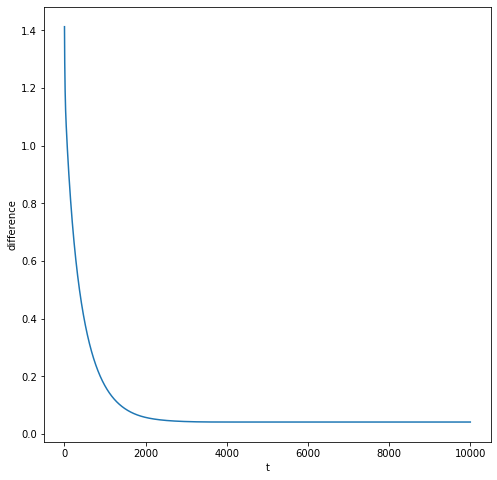

In [48]:
#1(b)
from scipy.sparse.linalg import eigs
M_transpose = (RW_M/np.sum(RW_M, axis=1).reshape(-1,1)).transpose()
#u1 is the first eigenvecot of M transpose
lambda1, u1 = eigs(M_transpose,k=1)

#w_infinite
W_inf = u1.flatten()/np.sum(u1.flatten())
#normalized random walk matrix
M = RW_M/np.sum(RW_M, axis=1).reshape(-1,1)
#w_0
w0 = np.random.uniform(size=(1,769))
w0 = w0/np.sum(w0, axis=1)
#w_1
W_t = np.matmul(w0,M)

diff = []
diff.append(np.sum(abs(W_t - W_inf))) 
for i in range(10000-1):
    #w_t
    W_t = np.matmul(W_t,M) 
    diff.append(np.sum(abs(W_t - W_inf)))  
    
#plot    
plt.figure(figsize=(8,8))
plt.plot(np.arange(1,10001), diff)
plt.xlabel('t')
plt.ylabel('difference')


In [121]:
#2(a)
document = pd.read_csv('nyt_data.txt',sep='\n',header=None)
document.head(10)

In [101]:
X = np.zeros([3012,8447])

In [144]:
j = 0
for k in range(0, document.shape[0]):
    each_document = document.iloc[k,:].tolist()[0].split(',')
    for words in each_document:

        i = int(words.split(':')[0])-1
        X[i, j] = int(words.split(':')[1])
    j =j+1

In [145]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [157]:
#NMF implementation
warning_space = 1e-16
objective_function = []
W= np.random.uniform(1,2,(3012,25))
H = np.random.uniform(1,2,(25,8447))
for i in range(0,100):
    #data matrix dot devided by its approximation
    purple = np.divide(X,np.matmul(W,H)+warning_space) 
    #normalized the transpose
    pink = W.transpose()/np.sum(W.transpose(), axis=1).reshape(-1,1)
    #update H
    H = np.multiply(H, np.matmul(pink, purple))
    
    
    purple = np.divide(X,np.matmul(W,H)+warning_space) 
    #normalized the transpose
    light_blue = H.transpose()/np.sum(H.transpose(), axis=0)
    #update W
    W = np.multiply(W, np.matmul(purple, light_blue))


    objective = np.sum(np.multiply(np.log(1/(np.matmul(W,H)+warning_space)),X) + np.matmul(W,H))
    objective_function.append(objective)


Text(0, 0.5, 'objective function')

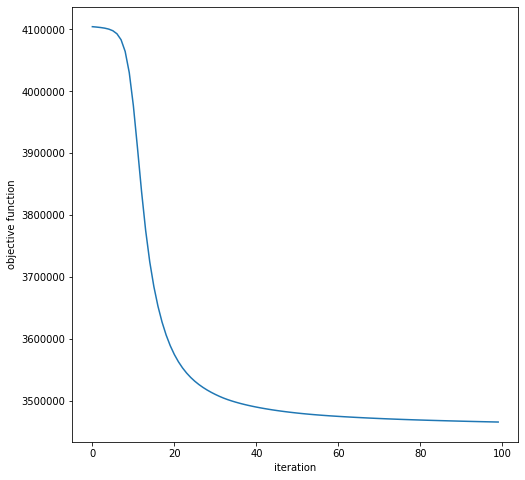

In [160]:
plt.figure(figsize=(8,8))
plt.plot(np.arange(0,100), objective_function)
plt.xlabel('iteration')
plt.ylabel('objective function')

In [224]:
#start 2b

vocab = pd.read_csv('nyt_vocab.dat', header=None)
vocab = pd.DataFrame({'vocab':vocab.iloc[:,0].tolist()})
vocab.head(10)

,vocab
0,company
1,percent
2,state
3,play
4,official
5,game
6,man
7,city
8,plan
9,school


In [226]:
W_norm=W/np.sum(W, axis=0)
weight_column = pd.DataFrame(W_norm)
final_table = []
for i in range(weight_column.shape[1]):
    df =pd.DataFrame({'weight':weight_column.iloc[:,i].tolist()})
    df =df.sort_values(by='weight', ascending=False).iloc[0:10,:]
    topic = pd.concat([df, vocab], axis=1, join='inner')
    final_table.append(topic)  

In [27]:
#display tables
#reference: https://github.com/epmoyer/ipy_table/issues/24
from IPython.core.display import HTML

def multi_table(table_list):
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [253]:
table1= final_table[0]
table2=final_table[1]
table3 = final_table[2]
table4 = final_table[3]
table5 = final_table[4]
table6 = final_table[5]
table7 = final_table[6]
table8 = final_table[7]
table9 = final_table[8]
table10 = final_table[9]
table11 = final_table[10]
table12 = final_table[11]
table13 = final_table[12]
table14 = final_table[13]
table15 = final_table[14]
table16 = final_table[15]
table17 = final_table[16]
table18 = final_table[17]
table19 = final_table[18]
table20 = final_table[19]
table21= final_table[20]
table22=final_table[21]
table23 = final_table[22]
table24 = final_table[23]
table25 = final_table[24]

In [251]:
multi_table([table1,table2,table3,table4,table5])

,weight,vocab
67,0.027570,police
88,0.020943,charge
6,0.017194,man
405,0.014751,crime
558,0.013958,arrest
169,0.012504,officer
17,0.011237,case
630,0.011063,victim
629,0.010786,prison
404,0.010270,trial


In [252]:
multi_table([table6,table7,table8,table9,table10])

,weight,vocab
48,0.016902,law
17,0.014226,case
126,0.013761,court
162,0.012250,lawyer
207,0.010592,rule
4,0.010356,official
27,0.010165,issue
477,0.010116,legal
137,0.009315,decision
2,0.008382,state


In [254]:
multi_table([table11,table12,table13,table14,table15])

,weight,vocab
173,0.021172,television
54,0.016947,name
33,0.015000,president
650,0.013488,advertising
764,0.013446,video
69,0.013130,executive
511,0.012487,medium
55,0.012204,director
321,0.012055,movie
659,0.011845,magazine


In [255]:
multi_table([table16,table17,table18,table19,table20])

,weight,vocab
7,0.013647,city
102,0.013379,area
149,0.012096,build
330,0.010378,resident
200,0.010142,project
350,0.009467,plant
2,0.009301,state
8,0.008851,plan
121,0.008144,building
233,0.007762,water


In [257]:
multi_table([table21,table22,table23,table24,table25])

,weight,vocab
75,0.020559,political
132,0.019616,campaign
150,0.018580,vote
319,0.016189,candidate
120,0.015898,party
216,0.015526,election
253,0.014392,republican
84,0.012990,leader
383,0.012554,democratic
2,0.010771,state
